## Sequence to Sequence: Encoder & Decoder Architecture

In [3]:
import copy
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split, \
TensorDataset
from data_generation.square_sequence import generate_sequences
from stepbystep.v4 import StepByStep

In [4]:
#Creating data points (of squares) and their direction
points, directions=generate_sequences(n=128, seed=13)

## Encoder
" The encoder's goal is to generate a representation of the $\textbf{source sequence}$, that is, to encode it

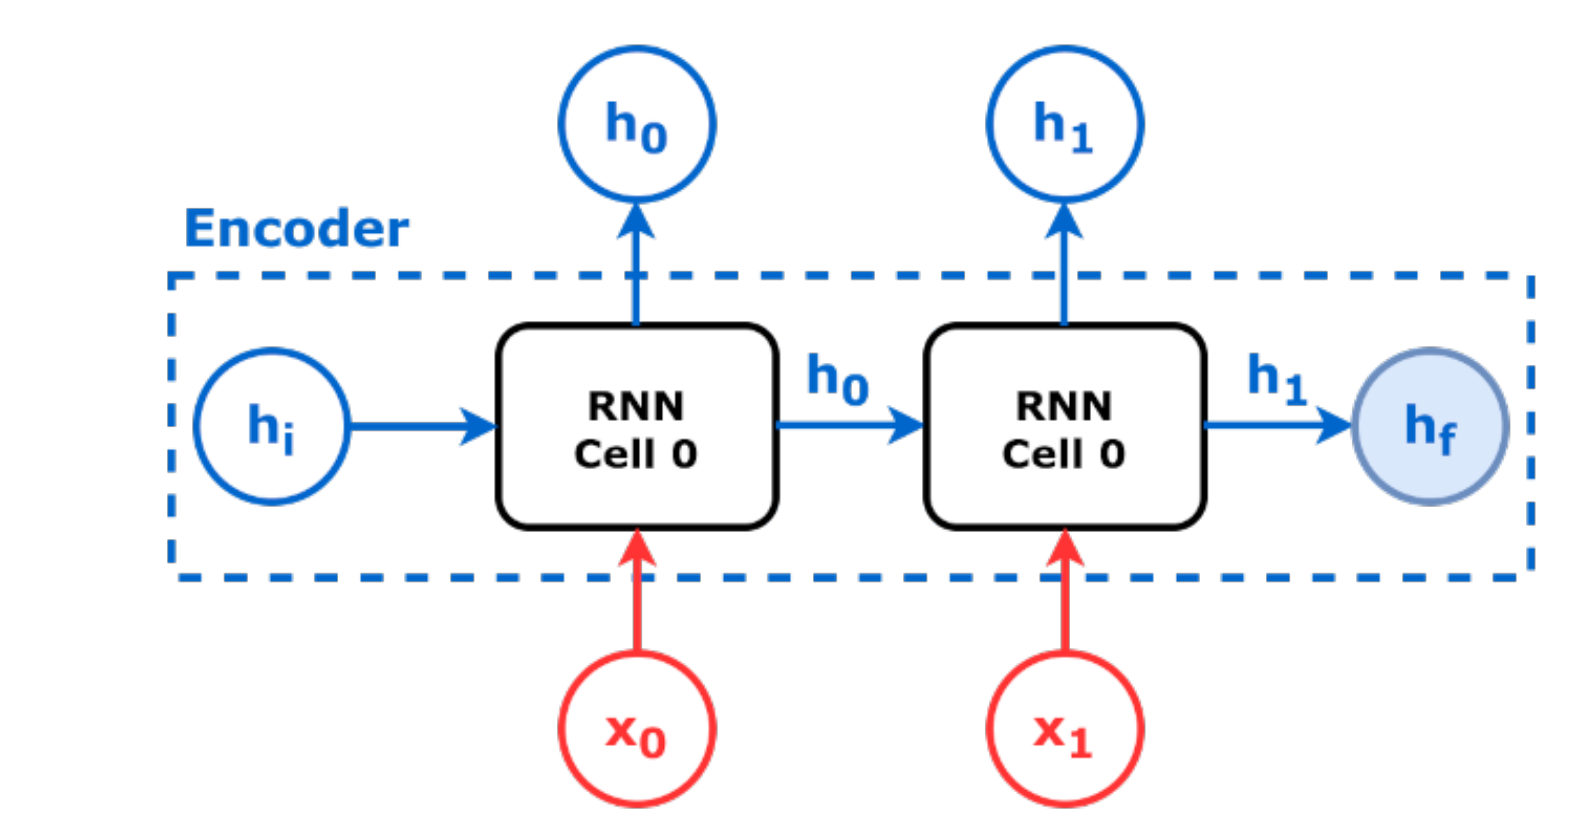

In [5]:
class Encoder(nn.Module):
    def __init__(self, n_features, hidden_dim):
        self.hidden_dim=hidden_dim
        self.n_features=n_features
        self.hidden=None
        self.basic_rnn=nn.GRU(
        self.n_features,
        self.hidden_dim,
        batch_first=True)
    
    def forward(self, X):
        rnn_out, self.hidden=self.self.basic_rnn(X)
        
        return rnn_out
        

In [6]:
#ejemplo de un cuadrado perfecto
full_seq=(torch.tensor([[-1,-1],[-1,1],[1,1],[1,-1]])).float().view(1,4,2)
source_seq=full_seq[:,:2,:]
target_seq=full_seq[:,2:,:]

In [8]:
source_seq, source_seq.size()

(tensor([[[-1., -1.],
          [-1.,  1.]]]),
 torch.Size([1, 2, 2]))